## Polynomial Regression
Recall that polynomial regression is linear regression with an additional step of polynomial transformation
```
Features ---> polynomial transformation ---> Linear regression ---> Label
```
We will use ``LinReg``  class that implements linear regression model

We will implement
- Polynomial transformation function

A few helper functions for 
- Generation of training data with non-linear relationship between features and labels. We generate examples with single feature $x_1$ and label $y$.
- Visualization of training data and model fitment.

We use polynomial transformations of different degrees for modeling relationships between icput features and labels. Each degree results in a new polynomial model. Thus we have multiple polynomial models from which we need to select the best performing model. 

In [1]:
from IPython.display import display, Math, Latex
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
cp.random.seed(100)

In [3]:
class LinearRegression(object):
    '''
    Linear Regression model
    -----------------------
    y = X @ w
    X: A feature matrix
    w: weight vector
    y: label vector
    '''

    def __init__(self):
        self.t0 = 200
        self.t1 = 100000
        self.w = cp.array([])
    

    def predict(self, X: cp.ndarray) -> cp.ndarray:
        '''
        Prediction of output label for a given icput.

        Args:
            X: Feature matrix for given icputs.
        Returns:
            y: Output vector as predicted by the given model.
        '''
        y = X @ self.w
        return y
    
    def loss(self, X: cp.ndarray, y: cp.ndarray) -> float:
        '''
        Calculate the loss for a model based on known labels

        Args:
            X: Feature matrix for given icputs.
            y: Output label vector as predicted by the given model.
        Returns:
            Loss
        '''

        err = y - self.predict(X)
        return 0.5 * cp.transpose(err) @ err
    
    def rmse(self, X: cp.ndarray, y: cp.ndarray) -> float:
        '''
        Calculate the root mean squared error of predictions w.r.t actual label.

        Args:
            X: Feature matrix for given icputs.
            y: Output label vector as predicted by the given model
        Returns:
            Loss
        '''
        return cp.sqrt((2 / X.shape[0]) * self.loss(X, y))
    
    def fit(self, X: cp.ndarray, y: cp.ndarray) -> cp.ndarray:
        '''
        Estimates the parameters of the linear regression model with normal equation

        Args:
            X: Feature matrix for given icputs.
            y: Output label vector as predicted by the given model
        Returns:
            weight vector
        '''
        self.w = cp.linalg.pinv(X) @ y
        return self.w
    
    def calculate_gradient(self, X: cp.ndarray, y: cp.ndarray) -> cp.ndarray:
        '''
        Calculates gradients of loss function w.r.t weight vector on training set.
        Args:
            X: Feature matrix for given icputs.
            y: Output label vector as predicted by the given model
        Returns:
            a vector of gradients.
        '''
        return cp.transpose(X) @ (self.predict(X) - y)
    
    def learning_schedule(self, t):
        return self.t0 / (t + self.t1)
    
    def gd(self, X: cp.ndarray, y:cp.ndarray, num_epochs:int, lr:float) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            lr: learning rate

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1]))
        self.w_all = []
        self.err_all = []
        for i in cp.arange(0,num_epochs):
            dJdw = self.calculate_gradient(X, y)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X, y))
            self.w = self.update_weights(dJdw, lr)
        return self.w
    
    def mbgd (self, X:cp.ndarray, y:cp.ndarray, num_epochs:int, batch_size:int) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            batch_size: Number of examples in a batch

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1]))
        self.w_all = []
        self.err_all = []
        mini_batch_id = 0

        for epoch in range(num_epochs):
            shuffled_indices = cp.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                xi = X_shuffled[i: i+batch_size]
                yi = y_shuffled[i: i+batch_size]
                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi, yi))

                dJdw = 2/batch_size * self.calculate_gradient(xi, yi)
                self.w = self.update_weights(dJdw, self.learning_schedule(mini_batch_id))
            
        return self.w
    
    def sgd (self, X: cp.ndarray, y:cp.ndarray, num_epochs:int) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            batch_size: Number of examples in a batch

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1]))
        self.w_all = []
        self.err_all = []
        
        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index = cp.random.randint(X.shape[0])
                xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi))

                gradients = 2 * self.calculate_gradient(xi, yi)
                lr = self.learning_schedule(epoch * X.shape[0] +i)
                self.w = self.update_weights(gradients, lr)
        
        return self.w

#### Polynomial Transformation

Steps for generating polynomial transformation of degree $M$
- Generate combination of input features of lengths = $0,1,..., M$
- Perform multiplication operation between features to obtain new features

For example:
- For a single feature $x_1, \phi_m = [1 , x_1^1 , x_1^2 , ... , x_1^m]$
  - Generate combinations of $\{1 , x_1 , (x_1,x_1) , (x_1,x_1,x_1) , ... , (x_1, x_1, ... (m times))\}$
    - 0-th degree: 1
    - 1-st degree: $x_1$
    - 2-nd degree: $(x_1,x_1)$
    - 3-rd degree: $(x_1,x_1,x_1)$
    - m-th degree: $(x_1,x_1,....,m$ times)
  - Taking the product of elements in combination:
  $$\phi_m(x_1)  = \{1,x_1,x_1^2,x_1^3,...,x_1^m\}$$

  - For two features say $(x_1,x_2)$ obtain $\phi_2(x_1,x_2)$:
    - Generate combinations of $\{1,x_1,x_2,(x_1,x_1),(x_2,x_2),(x_1,x_2)$
      - 0-th degree: 1
      - 1-st degree: $x_1,x_2$
      - 2-nd degree: $(x_1,x_1),(x_2,x_2),(x_1,x_2)$
    - Taking product of the elements in combination:
    $$\phi_2(x_1,x_2) = \{1,x_1,x_2,x_1^2,x_2^2,x_1x_2\}$$
  - Similarly $\phi_3(x_1,x_2) = \{1,x_1,x_2,x_1^2,x_2^2,x_1^3,x_1^2x_2,x_1x_2^2,x_2^3\}$

In [4]:
import itertools
import functools

def get_combinations (x, degree):
    return itertools.combinations_with_replacement(x, degree)

def compute_new_features(items):
    # reduce (lambda x, y: x*y,[1,2,3,4,5]) calculates ((((1*2)*3)*4)*5)
    return functools.reduce(lambda x, y: x*y, items)

Let's run ``get_combinations`` with few examples.

In [5]:
{items: compute_new_features(items) for items in get_combinations([1],3)}

{(1, 1, 1): 1}

In [6]:
{items: compute_new_features(items) for items in get_combinations([2,3],3)}

{(2, 2, 2): 8, (2, 2, 3): 12, (2, 3, 3): 18, (3, 3, 3): 27}

In [7]:
{items: compute_new_features(items) for items in get_combinations([1,4],4)}

{(1, 1, 1, 1): 1,
 (1, 1, 1, 4): 4,
 (1, 1, 4, 4): 16,
 (1, 4, 4, 4): 64,
 (4, 4, 4, 4): 256}

In [8]:
# Implementation adopted from (https://github.com/ctgk/PRML/blob/main/prml/preprocess/polynomial.py)

import cupy as cp
import itertools
import functools

def polynomial_transform(x, degree, logging=False):
    # Converts to feature matrix
    if x.ndim == 1:
        x = x[:, None]
    x_t = x.transpose()
    features = [cp.ones(len(x))] # Populates 1s as first feature for each example

    if logging:
        print("Input:", x)
    for degree in range(1,degree+1):
        for items in get_combinations(x_t, degree):
            features.append(compute_new_features(items))
            if logging:
                print(items, ":", compute_new_features(items))
    if logging:
        print(cp.asarray(features).transpose())
    return cp.asarray(features).transpose()

In [9]:
polynomial_transform(cp.array([2]),3, logging=True)

Input: [[2]]
(array([2]),) : [2]
(array([2]), array([2])) : [4]
(array([2]), array([2]), array([2])) : [8]
[[1. 2. 4. 8.]]


array([[1., 2., 4., 8.]])

In [10]:
polynomial_transform(cp.array([2,3]),2, logging=True)

Input: [[2]
 [3]]
(array([2, 3]),) : [2 3]
(array([2, 3]), array([2, 3])) : [4 9]
[[1. 2. 4.]
 [1. 3. 9.]]


array([[1., 2., 4.],
       [1., 3., 9.]])

In [11]:
polynomial_transform(cp.array([[2,3],[4,5]]),degree=2,logging=True)

Input: [[2 3]
 [4 5]]
(array([2, 4]),) : [2 4]
(array([3, 5]),) : [3 5]
(array([2, 4]), array([2, 4])) : [ 4 16]
(array([2, 4]), array([3, 5])) : [ 6 20]
(array([3, 5]), array([3, 5])) : [ 9 25]
[[ 1.  2.  3.  4.  6.  9.]
 [ 1.  4.  5. 16. 20. 25.]]


array([[ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [12]:
polynomial_transform(cp.array([[2,3],[4,5]]),degree=3,logging=True)

Input: [[2 3]
 [4 5]]
(array([2, 4]),) : [2 4]
(array([3, 5]),) : [3 5]
(array([2, 4]), array([2, 4])) : [ 4 16]
(array([2, 4]), array([3, 5])) : [ 6 20]
(array([3, 5]), array([3, 5])) : [ 9 25]
(array([2, 4]), array([2, 4]), array([2, 4])) : [ 8 64]
(array([2, 4]), array([2, 4]), array([3, 5])) : [12 80]
(array([2, 4]), array([3, 5]), array([3, 5])) : [ 18 100]
(array([3, 5]), array([3, 5]), array([3, 5])) : [ 27 125]
[[  1.   2.   3.   4.   6.   9.   8.  12.  18.  27.]
 [  1.   4.   5.  16.  20.  25.  64.  80. 100. 125.]]


array([[  1.,   2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

In [13]:
polynomial_transform(cp.array([2]),degree=0)

array([[1.]])

### Non-linear training data generation
We generate training data with a single feature $x_1$ and label $y = sin(2\pi x_1) + noise$

In [14]:
'''
Create a training set where output label is obtained by first calculating
sin(2*pi*x) and then adding a small random noise having a gaussian distribution.
'''
def create_nonlin_training_set(func, sample_size, std):
    x = cp.linspace(0, 1, sample_size)
    y = func(x) + cp.random.normal(scale= std, size= x.shape)
    return x, y

def nonlin(x):
    return cp.sin(2* cp.pi * x)

In [15]:
# @title [Visualization]
def visualize_training_data(X_train, y_train):
    points = cp.linspace(0,1,100)
    output = nonlin(points)

    plt.scatter(X_train.get(), y_train.get(), facecolor="none", edgecolor="blue",s=50, label="training_data")
    plt.plot(points.get(), output.get(), c="g", label="$\\sin(2\\pi x)$")
    plt.xlabel("$x_1$")
    plt.ylabel('y')
    plt.legend()
    plt.show()

def visualize_model_fit(X, y, lin_reg, degree):
    '''
    Plots trained model along with data degeneration function
    '''
    points = cp.linspace(0, 1, 100)
    output = nonlin(points)

    if degree > 0:
        plt.scatter(X.get(), y.get(), facecolor="none", edgecolor="blue",s=50, label="training_data")
        plt.plot(points.get(), output.get(), c="g", label="$\\sin(2\\pi x)$")
        
        y_hat = lin_reg.predict(polynomial_transform(points,degree=degree))
        plt.plot(points.get(), y_hat.get(), c='r', label="$h_\\mathbf{w}{x}$")
        plt.xlabel('$x_1$')
        plt.ylabel('y')
        plt.ylim(-1.5,1.5)
        plt.title("M={}".format(degree))

We can set the number of samples required and control noise added to examples through ``std`` parameter

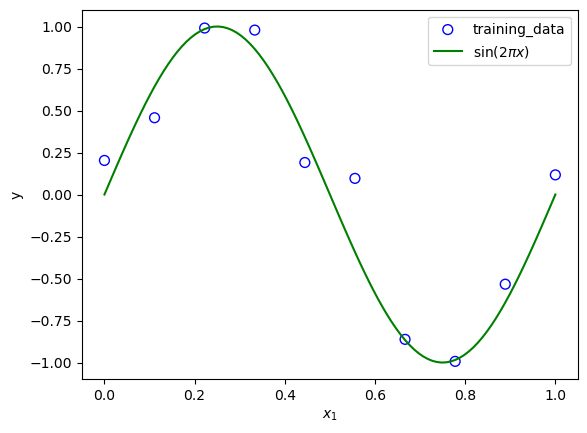

In [16]:
num_samples = 10 # Change the number to 100,1000,10000 and observe the models
X, y = create_nonlin_training_set(nonlin, num_samples, 0.2)
visualize_training_data(X, y)

### Polynomial model
Let's train a polynomial model on this data

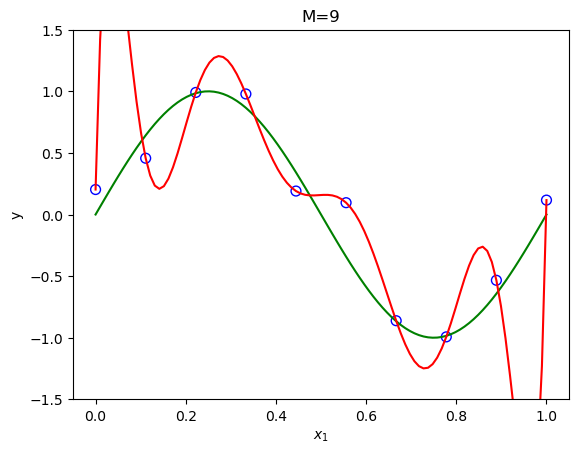

In [17]:
degree = 9
X_transform = polynomial_transform(X, degree)
lin_reg = LinearRegression()
lin_reg.fit(X_transform, y)
visualize_model_fit(X, y, lin_reg=lin_reg,degree=degree)

Let's train multiple polynomial regression models with different degrees

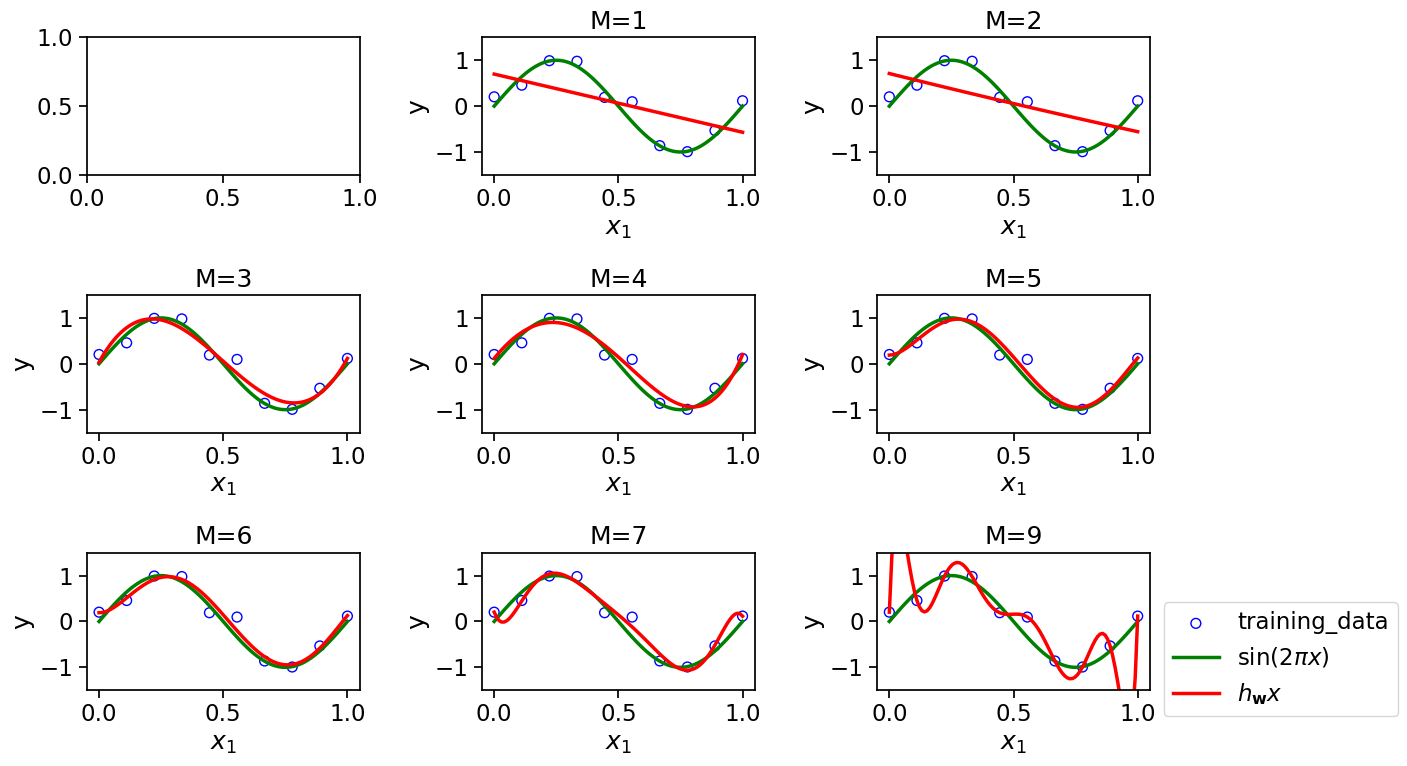

In [18]:

f = plt.figure(figsize=(12,8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth":2.5})

for i,degree in enumerate([0,1,2,3,4,5,6,7,9]):
    plt.subplot(3,3,i+1)
    X_transform = polynomial_transform(X,degree)
    lin_reg = LinearRegression()
    lin_reg.fit(X_transform,y)
    visualize_model_fit(X, y, lin_reg, degree)

f.tight_layout()
plt.legend(bbox_to_anchor=(1.05,0.64),loc=2,borderaxespad=0.)
plt.show()

### Model selection
- One polynomial model per degree. Which one to select?
- Process
  - Fix the list of degrees that you want to experiment with.
  - Divide the training data into training, validation and test
  - For each degree $m$:
    - Training polynomial regression model with training data
    - Calculate training and validation errors on the trained model.
- Select the model with the lowest training and validation loss among all models

In [19]:
#@title [Model selection helpers]
import pandas as pd

def convert_dict_to_df(w_dict,degree):
    poly_w_dict = {i: cp.array(cp.zeros(degree)).get() for i in range(degree)}

    for deg in poly_w_dict:
        weight_vec = w_dict[deg]
        for i in range(len(weight_vec)):
            poly_w_dict[deg][i] = weight_vec[i]
    
    poly_w_df = pd.DataFrame(poly_w_dict)
    poly_w_df.columns = ['w_'+str(i) for i in range(degree)]
    return poly_w_df

def plot_model_selection(training_errors, val_errors):
    plt.plot(training_errors, 'o-', mfc="none", mec='b', ms=10, c='b',label="Training errors")
    plt.plot(val_errors,'o-', mfc="none", mec='r', ms=10, c='r', label="validation errors")
    plt.legend()
    plt.xlabel("Degree")
    plt.ylabel("RMSE")
    plt.show()
    

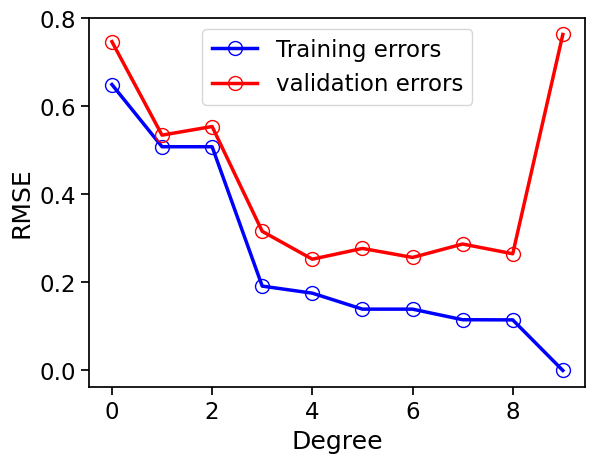

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9
0,0.064407,0.698302,0.710653,0.035655,0.117417,0.190051,0.190907,0.203935,0.204480,0.202832
1,0.000000,-1.267789,-1.351157,9.762197,6.696137,0.079139,-0.149272,-14.238568,-18.135743,153.882527
2,0.000000,0.000000,0.083368,-29.206709,-13.723104,41.433675,44.251644,276.736058,355.328166,-3617.994197
3,0.000000,0.000000,0.000000,19.526719,-5.308372,-161.218201,-173.347001,-1552.006137,-2144.793363,33644.382292
4,0.000000,0.000000,0.000000,0.000000,12.417545,191.125509,214.564124,4112.806960,6349.064018,-161783.711972
5,0.000000,0.000000,0.000000,0.000000,0.000000,-71.483186,-92.332243,-5777.106469,-10432.778738,447623.353983
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.949686,4132.426777,9564.044424,-740475.133933
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1178.707740,-4504.187933,722987.228787
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,831.370048,-384064.511415
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,85532.418103


In [20]:
training_errors = []
val_errors = []
w_dict = {}
X_val = cp.linspace(0, 1, 100)
y_val = nonlin(X_val)

for i in range(10):
    X_transform = polynomial_transform(X, i)
    X_val_transform = polynomial_transform(X_val, i)
    lin_reg = LinearRegression()
    lin_reg.fit(X_transform, y)

    w_dict[i] = lin_reg.w
    training_errors.append(lin_reg.rmse(X_transform, y))
    val_errors.append(lin_reg.rmse(X_val_transform, y_val + cp.random.normal(
                                                        scale=0.25, size=len(y_val))))

plot_model_selection(training_errors=cp.array(training_errors).get(), val_errors= cp.array(val_errors).get())
convert_dict_to_df(w_dict=w_dict, degree=10)

Observations:
- Higher order polynomial terms are assigned larged weights. The larger weights are problematic as small change in the input causes a large change in the output.

e.g $y = -0.53 + 185x_1+894x_1^2+3250x_1^3$ and change in x from 1 to 2 and calculate $y$ values
$$h_w(x_1 =1) = -0.53+ 185+894+3250=4328.47$$
$$h_w(x_1 =2) = -0.53+185*2+894*4+3250*8=29945.47$$
This is called 'high variance' problem  or overfitting problem.
- We can fix the overfitting problem with more data. Try running the analysis with number of samples = 100,1000,10000 and observe the weight vectors for higher order polynomial models.
- Note down which polynomial model is suitable for different sample sizes.

## Ridge and Lasso Regression
We will implement the ridge regression from scratch and demonstrate lasso from sklearn library

Polynomial regression is able to model non-linear relationship between features and labels. However higher order polynomials are prone to overfitting. There are two ways to tackle the problem of overfitting:
1. Train with more data.
2. Penalize the weight vector through regularization.

- Regularization leads to change in Linear Regression loss function, which inturn results in change of gradient calculation.
- We plan to demonstrate the use of regularization with polynomial regression models and synthetically generated non-linear data set.

The change in regularization rate results in a new model. For different values of regularization weights, we obtain a new model. Thus we have a problem of model selection at hand, where we need to choose the best model among the list of candidate models.

Finally we will demonstrate ridge and lasso regression solution path as function of regularization rate $\lambda$.

We will implement ridge regression by making the following changes(in blue color) to Linear Regression implementation:
1. Loss Function (``loss``):  $\bf J(w) = \frac{1}{2}(Xw - y)^T(Xw - y) + \textcolor{blue}{\frac{\lambda}{2}w^Tw}$


2. Gradient calculation (``calculate_gradient``): $\bf \frac{\partial J(w)}{\partial w} = X^T(Xw - y) + \textcolor{blue}{\lambda w}$


3. Normal equation (``fit``): $\bf w = (X^TX + \textcolor{blue}{\lambda I})^{-1}X^Ty$

In [21]:
class RidgeRegression(object):
    '''
    Linear Regression model
    -----------------------
    y = X @ w
    X: A feature matrix
    w: weight vector
    y: label vector
    '''

    def __init__(self):
        self.t0 = 200
        self.t1 = 100000
    
    def predict(self , X:cp.ndarray) -> cp.ndarray:
        '''
        Prediction of output label for a given input.

        Args:
            X: Feature matrix for given inputs.
        Returns:
            y: Output vector as predicted by the given model.
        '''
        y = X @ self.w
        return y
    
    def loss(self, X: cp.ndarray, y: cp.ndarray, reg_rate: float) -> float:
        '''
        Calculate the loss for a model based on known labels

        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model.
        Returns:
            Loss
        '''

        e = y - self.predict(X)
        # return 0.5 * (np.transpose(e) @ e) # Old loss function
        return 0.5* (cp.transpose(e)) @ e + (reg_rate/2) * (cp.transpose(self.w) @ self.w)
    
    def rmse (self, X: cp.ndarray, y: cp.ndarray,reg_rate:float=0) -> float:
        '''
        Calculate the root mean squared error of predictions w.r.t actual label.

        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model
        Returns:
            Loss
        '''
        return cp.sqrt((2/X.shape[0])) * self.loss(X,y,reg_rate)
    

    def fit (self, X: cp.ndarray, y: cp.ndarray, reg_rate: float) -> cp.ndarray:
        '''
        Estimates the parameters of the linear regression model with normal equation

        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model
        Returns:
            weight vector
        '''
        #self.w = np.linalg.pinv(X) @ y
        #return self.w
        self.w = cp.zeros((X.shape[1]))
        eye = cp.eye(cp.size(X,1)) # Identity matrix
        self.w = cp.linalg.solve(
            reg_rate * eye + X.T @ X,
            X.T @ y
        )
        return self.w
    

    def calculate_gradient(self, X: cp.ndarray, y: cp.ndarray, reg_rate: float) -> cp.ndarray:
        '''
        Calculates gradients of loss function w.r.t weight vector on training set.
        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model
        Returns:
            a vector of gradients.
        '''
        return cp.transpose(X) @ (self.predict(X) - y) + reg_rate * self.w
    
    def update_weights (self, grad:cp.ndarray, lr: float) -> cp.ndarray:
        '''
        Updates the weights based on the gradient of the loss function.

        Weight updates are carried out with the following formula:
            w_new := w_old - lr * grad
        Args:
            1. w: weight vector
            2. grad: gradient of loss w.r.t w
            3. lr: learning rate
        Returns:
            Updated weight vector
        '''
        return (self.w - lr * grad)

    def learning_schedule(self, t):
        return self.t0 / (t + self.t1)
    
    def gd(self, X: cp.ndarray, y:cp.ndarray, num_epochs:int, lr:float,reg_rate:float=0) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            lr: learning rate

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1]))
        self.w_all = []
        self.err_all = []
        for i in cp.arange(0,num_epochs):
            dJdw = self.calculate_gradient(X, y,reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y,reg_rate))
            self.w = self.update_weights(dJdw, lr,reg_rate)
        return self.w
    
    def mbgd (self, X:cp.ndarray, y:cp.ndarray, num_epochs:int, batch_size:int,reg_rate:float=0) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            batch_size: Number of examples in a batch

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1]))
        self.w_all = []
        self.err_all = []
        mini_batch_id = 0

        for epoch in range(num_epochs):
            shuffled_indices = cp.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                xi = X_shuffled[i: i+batch_size]
                yi = y_shuffled[i: i+batch_size]
                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi, yi,reg_rate))

                dJdw = 2/batch_size * self.calculate_gradient(xi, yi,reg_rate)
                self.w = self.update_weights(dJdw, self.learning_schedule(mini_batch_id))
            
        return self.w
    
    def sgd (self, X: cp.ndarray, y:cp.ndarray, num_epochs:int,reg_rate:float=0) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            batch_size: Number of examples in a batch

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1]))
        self.w_all = []
        self.err_all = []
        
        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index = cp.random.randint(X.shape[0])
                xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi,reg_rate))

                gradients = 2 * self.calculate_gradient(xi, yi,reg_rate)
                lr = self.learning_schedule(epoch * X.shape[0] +i)
                self.w = self.update_weights(gradients, lr)
        
        return self.w

In [22]:
# @title [Visualization]
def visualize_training_data(X_train, y_train):
    points = cp.linspace(0,1,100)
    output = nonlin(points)

    plt.scatter(X_train.get(), y_train.get(), facecolor="none", edgecolor="blue",s=50, label="training_data")
    plt.plot(points.get(), output.get(), c="g", label="$\\sin(2\\pi x)$")
    plt.xlabel("$x_1$")
    plt.ylabel('y')
    plt.legend()
    plt.show()

def visualize_model_fit(X, y, lin_reg, degree, reg_rate=0):
    '''
    Plots trained model along with data degeneration function
    '''
    points = cp.linspace(0, 1, 100)
    output = nonlin(points)

    if degree > 0:
        plt.scatter(X.get(), y.get(), facecolor="none", edgecolor="blue",s=50, label="training_data")
        plt.plot(points.get(), output.get(), c="g", label="$\\sin(2\\pi x)$")
        
        y_hat = lin_reg.predict(polynomial_transform(points,degree=degree))
        plt.plot(points.get(), y_hat.get(), c='r', label="$h_\\mathbf{w}{x}$")
        plt.xlabel('$x_1$')
        plt.ylabel('y')
        plt.ylim(-1.5,1.5)
        plt.title("M={},$\\lambda$={}".format(degree,reg_rate))

In [23]:
import unittest

class TestLossFunction ( unittest.TestCase):
    
    def test_loss_function(self):
        ''' Test case for loss function of linear regression'''
        # set up
        feature_matrix = cp.array([[1,3,2,5],[1,9,4,7]])
        weight_vector = cp.array([1,1,1,1])
        label_vector = cp.array([6,11])
        reg_rate = 0.01
        expected_loss = cp.array([62.52])

        #call
        lin_reg = RidgeRegression()
        lin_reg.w = weight_vector
        loss_value = lin_reg.loss(feature_matrix, label_vector, reg_rate)

        #asserts
        #test the shape
        self.assertEqual(loss_value.shape,())

        #and the contents
        cp.testing.assert_array_equal(expected_loss, loss_value)

unittest.main(argv=[''],defaultTest='TestLossFunction',verbosity=2,exit=False)

test_loss_function (__main__.TestLossFunction.test_loss_function)
Test case for loss function of linear regression ... 

ok

----------------------------------------------------------------------
Ran 1 test in 1.234s

OK


In [24]:
class TestCalculateGradient(unittest.TestCase):

    def test_calculate_gradient(self):
        '''
        Test case for gradient calculation
        '''

        feature_matrix = cp.array([[1, 3, 2, 5],[1, 9, 4, 7]])
        weight_vector = cp.array([1, 1, 1, 1])
        label_vector = cp.array([6, 11])
        reg_rate = 0.01
        expected_grad = cp.array([15.01, 105.01, 50.01, 95.01])

        # call
        lin_reg = RidgeRegression()
        lin_reg.w = weight_vector
        grad = lin_reg.calculate_gradient(feature_matrix,label_vector,reg_rate)

        # asserts
        # test the shape
        self.assertEqual(grad.shape, (4, ))

        # and the contents
        cp.testing.assert_array_almost_equal(expected_grad, grad, decimal=0)

unittest.main(argv=[''],defaultTest='TestLossFunction',verbosity=2,exit=False)

test_loss_function (__main__.TestLossFunction.test_loss_function)
Test case for loss function of linear regression ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### Ridge regression for fixing overfitting in polynomial regression

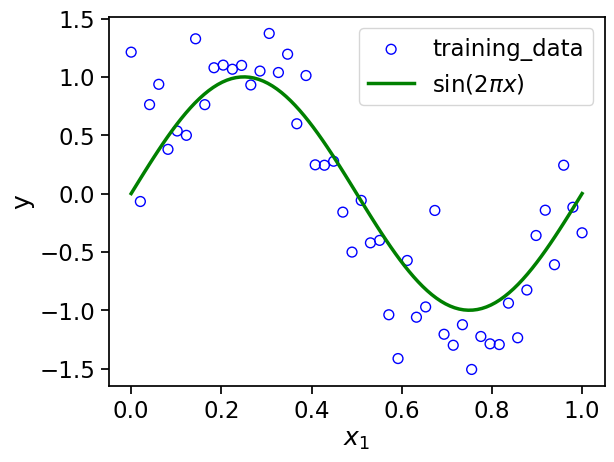

In [25]:
num_samples = 50
X, y = create_nonlin_training_set(nonlin, num_samples, 0.3)
visualize_training_data(X, y)

#### Polynomial model
Let's train multiple polynomial regression models with different degrees without regularization

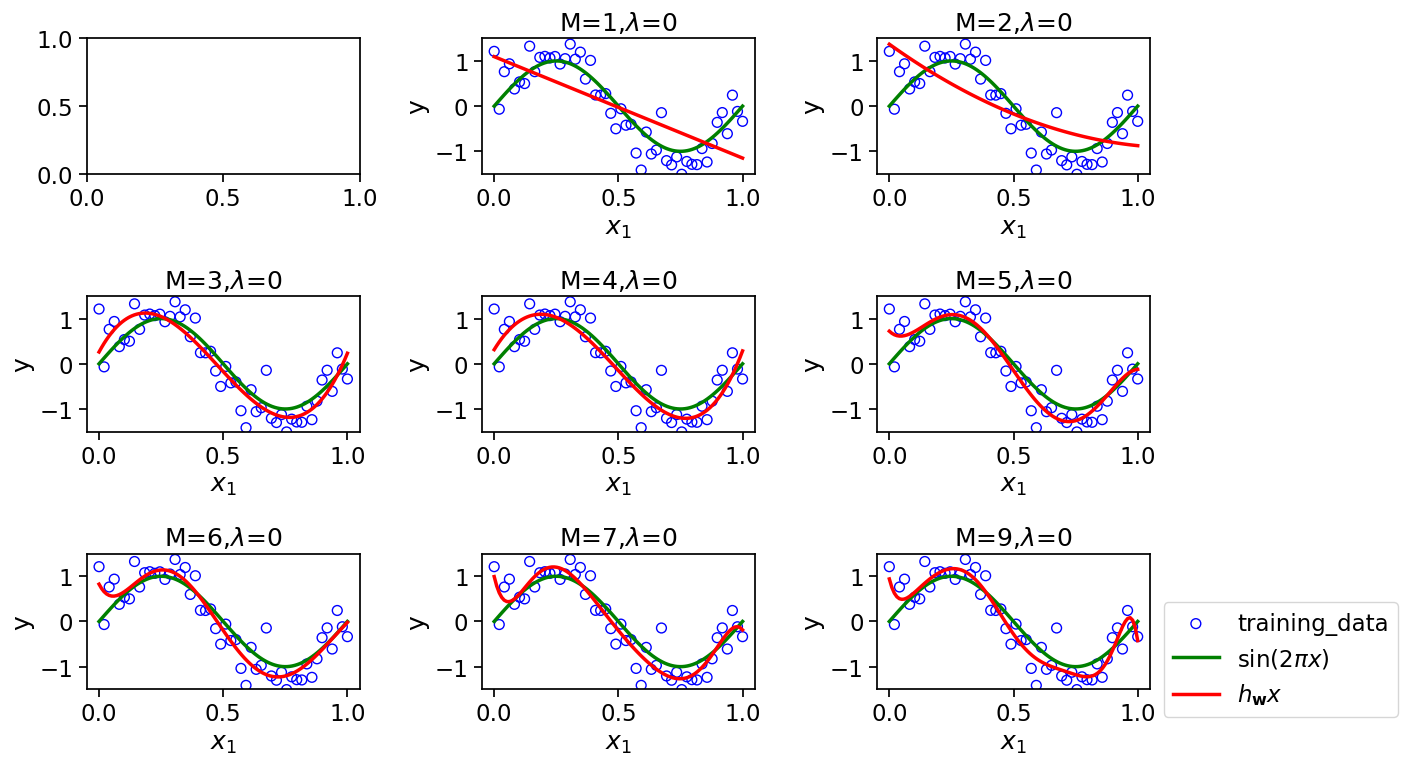

In [26]:
f = plt.figure(figsize=(12,8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth":2.5})

for i,degree in enumerate([0,1,2,3,4,5,6,7,9]):
    plt.subplot(3,3,i+1)
    X_transform = polynomial_transform(X,degree)
    lin_reg = RidgeRegression()
    lin_reg.fit(X_transform,y, reg_rate=0)
    visualize_model_fit(X, y, lin_reg, degree)

f.tight_layout()
plt.legend(bbox_to_anchor=(1.05,0.64),loc=2,borderaxespad=0.)
plt.show()

Let's run a polynomial regression of degree=9 with different regularization rate

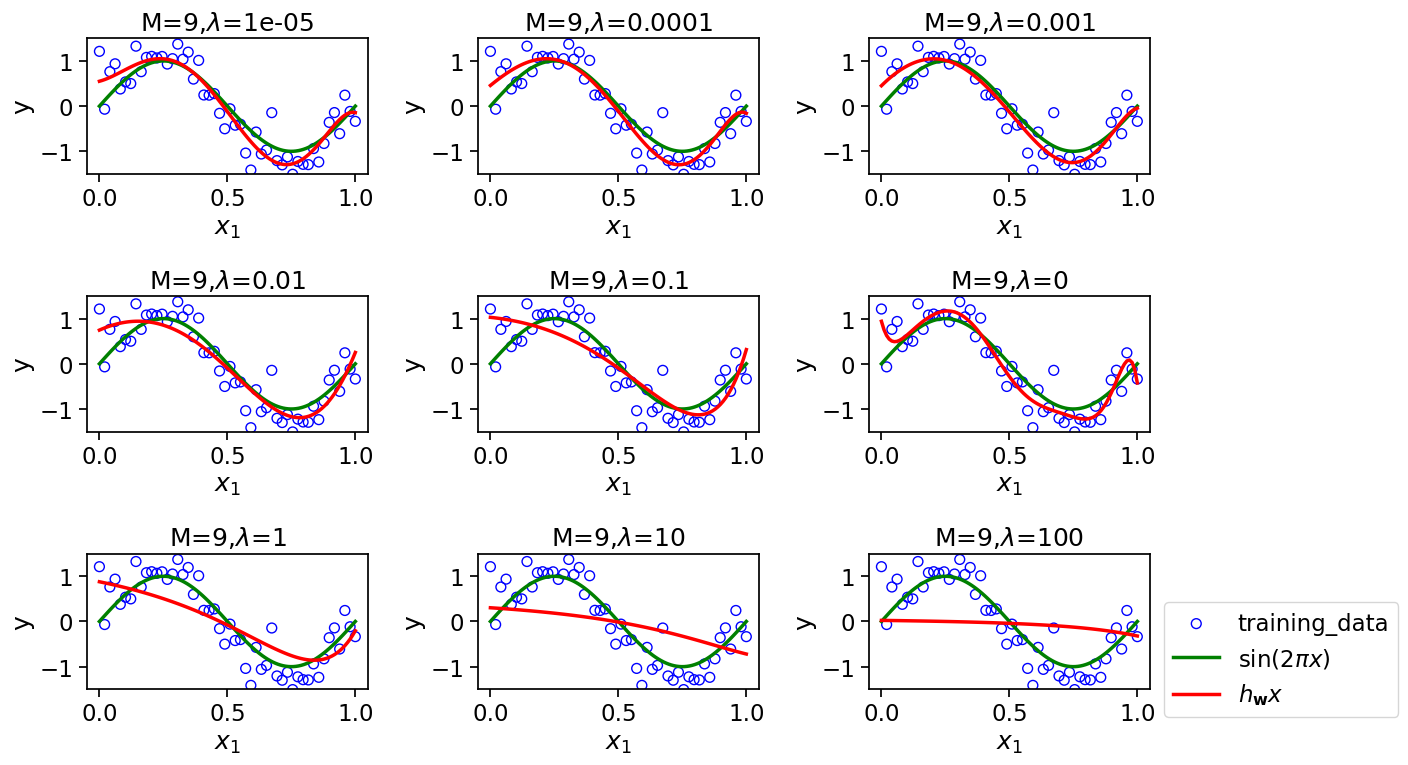

In [27]:
# Polynomial regression of fixed degree and varying regularization rate
f = plt.figure(figsize=(12,8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth":2.5})
degree = 9

for i, reg_rate in enumerate([1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10,100]):
    plt.subplot(3,3,i+1)
    X_transform = polynomial_transform(X,degree=degree)
    lin_reg = RidgeRegression()
    lin_reg.fit(X_transform,y, reg_rate)
    visualize_model_fit(X,y,lin_reg,degree,reg_rate)

f.tight_layout()
plt.legend(bbox_to_anchor=(1.05,0.64),loc=2,borderaxespad=0.)
plt.show()

#### Model selection
- One model per $\lambda$. Which one to select?
- Process
  - Fix the list of $\lambda$ that you want to experiment with.
  - Divide the training data into training, validation and test.
  - For each $\lambda$:
    - Training ridge regression model with $\lambda$ for training data.
    - Calculate training and validation errors on the trained model.
- Select the model with the lowest training and validation loss among all models.

In [28]:
#@ title [Model selection helper functions]

def plot_reg_w(w_df):
    ax = plt.gca()
    ax.plot(w_df.T)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.xlabel('$\\lambda$')
    plt.ylabel('$\\mathbf{w}$')
    plt.title('Weights as a function of $\\lambda$')
    plt.axis('tight')
    plt.show()

def plot_learning_curve(err_df):
    ax = plt.gca()
    ax.plot(err_df)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.xlabel('$\\lambda$')
    plt.ylabel('RMSE')
    plt.title('Training and validation losses as a function of $\\lambda$')
    plt.axis('tight')
    plt.legend(['training', 'validation'])
    plt.show()

In [29]:
import pandas as pd

training_errors = {}
val_errors = {}
w_dict = {}
degree = 9
X_val = cp.linspace(0,1,100)
y_val = nonlin(X_val)

X_transform = polynomial_transform(X, degree)
X_val_transform = polynomial_transform(X_val, degree)

for reg_rate in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]:
    lin_reg = RidgeRegression()
    lin_reg.fit(X_transform, y, reg_rate)

    w_dict[reg_rate] = lin_reg.w.get()
    training_errors[reg_rate] = lin_reg.rmse(X_transform, y).get()
    val_errors[reg_rate] = lin_reg.rmse(X_val_transform,
                                     y_val + cp.random.normal(scale=0.25,size=len(y_val))).get()
    #visualize_model_fit(X,y,lin_reg,degree,reg_rate)

err_df = pd.DataFrame([training_errors,val_errors]).T
w_df = pd.DataFrame(w_dict)

In [30]:
err_df

,0,1
0.000001,0.47512937995436677,0.8634201565110179
0.000010,0.49771500463944296,0.6997467322836763
0.000100,0.5143163840046453,0.5925264815748807
0.001000,0.5308424812919242,0.5299811516438213
0.010000,0.6730079199598099,0.8073284680102595
0.100000,0.9240556917672731,1.2692898381943638
1.000000,1.263633096070876,0.8985326584730162
10.000000,2.5876913135223942,2.0831996043334735
100.000000,3.567913749910881,3.0116291095212633


Let's plot learning curves with $\lambda$ on X-axis and RMSE on y-axis

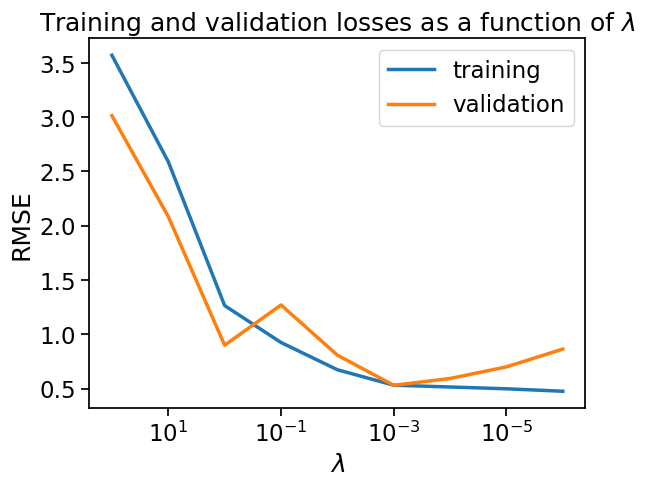

In [31]:
plot_learning_curve(err_df)

In [32]:
w_df

,0.000001,0.000010,0.000100,0.001000,0.010000,0.100000,1.000000,10.000000,100.000000
0,0.672238,0.550337,0.457491,0.451215,0.745451,1.027945,0.878450,0.303331,0.023632
1,-3.473253,1.486006,4.603667,5.608249,2.526312,-0.597876,-1.160486,-0.376496,-0.072721
2,59.504343,17.012003,-4.441551,-11.700669,-7.582954,-2.603402,-1.165121,-0.351083,-0.070281
3,-204.460674,-70.599328,-20.912929,-8.236152,-3.750378,-1.598313,-0.689635,-0.241327,-0.056291
4,187.924588,32.317006,3.225708,2.531023,1.163946,-0.318308,-0.236297,-0.142011,-0.043215
5,48.422203,39.974921,14.504535,8.446743,3.670650,0.549054,0.102848,-0.066153,-0.032862
6,-105.586644,3.459730,12.325417,8.614201,3.843147,0.982798,0.336728,-0.010831,-0.024983
7,-37.681867,-16.680965,4.945574,4.781432,2.419410,1.096743,0.491112,0.028955,-0.019023
8,89.337781,-10.318045,-3.238784,-1.456716,0.046397,1.000626,0.588938,0.057443,-0.014496
9,-34.766443,2.653752,-11.628613,-9.083749,-2.831040,0.775038,0.647303,0.077780,-0.011029


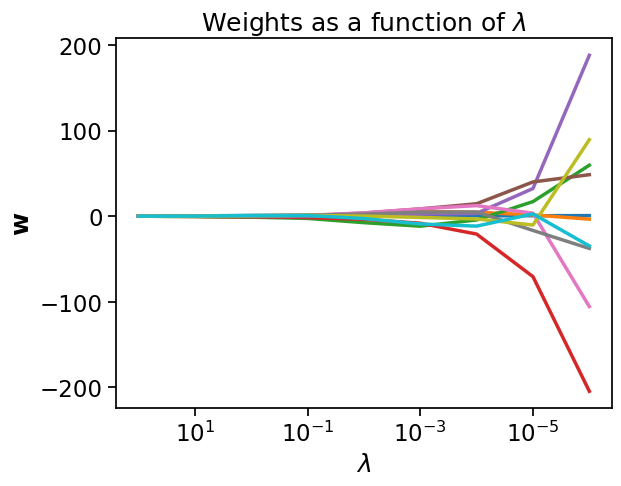

In [33]:
plot_reg_w(w_df)

## Lasso Regression
Lasso uses $\mathbf{L_1}$ norm of weight vector instead of $\mathbf{L_2}$ as used in ridge regression
Lasso does not have closed form solution and its loss function is not differentiable at all points. We need to use specialized algorithm to learn lasso parameters. We will use *sklearn* implementation

In [34]:
from cuml.linear_model import Lasso

reg_rate = 0.01
lasso = Lasso(alpha=reg_rate)
lasso.fit(X_transform, y)

lin_reg = RidgeRegression()
_ = lin_reg.fit(X_transform, y, 0)

Let's compare weight vectors of linear, ridge and lasso regressions

In [35]:
pd.DataFrame({'LinReg': lin_reg.w.get(),'Ridge':w_df[0.01], 'Lasso':lasso.coef_.get()})

,LinReg,Ridge,Lasso
0,0.940667,0.745451,0.000000
1,-22.008925,2.526312,-0.725825
2,369.609799,-7.582954,-2.841450
3,-2732.815730,-3.750378,0.000000
4,12328.839630,1.163946,0.000000
5,-35847.282606,3.670650,0.000000
6,64936.791438,3.843147,0.000000
7,-69772.094364,2.419410,0.000000
8,40489.084054,0.046397,1.722160
9,-9751.487954,-2.831040,0.896850


**Observations**:
1. Lasso obtains a sparse feature vector. Many 0 coefficients or weights
2. Ridge regression assigns small weights to each feature.

A couple of points about using Lasso and Ridge:
- Lasso is used for feature selection
- While modeling relationship between features and labels,
  - When all features are useful for making prediction about the output, we use ridge regression. It produces a weight vector with small non-zero values to all features.
  - When a few features are useful for making predictions, we use lasso, it produces weight vector that assigns 0 weights to unimportant features.

Let's visualize the models learnt by these three models.

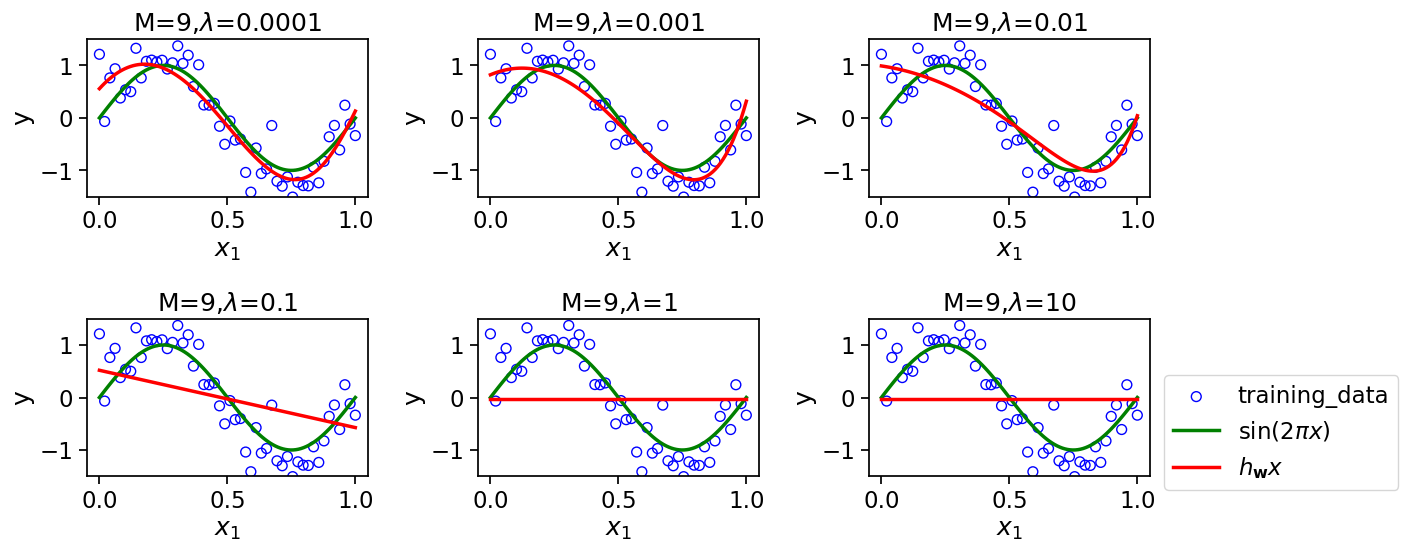

In [38]:
f = plt.figure(figsize=(12,8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth":2.5})

degree = 9
X_transform = polynomial_transform(X, degree)

for i ,reg_rate in enumerate([1e-4, 1e-3, 1e-2, 1e-1, 1, 10]):
    plt.subplot(3, 3,i+1)
    lasso = Lasso(alpha=reg_rate)
    lasso.fit(X_transform, y)
    visualize_model_fit(X, y,lasso, degree, reg_rate)

f.tight_layout()
plt.legend(bbox_to_anchor=(1.05,0.64), loc=2,borderaxespad=0.)
plt.show()

### Model selection

In [42]:
import pandas as pd
from cuml.metrics import mean_squared_error


training_errors = {}
val_errors = {}
w_dict = {}
degree = 9
X_val = cp.linspace(0,1,100)
y_val = nonlin(X_val)

X_transform = polynomial_transform(X, degree)
X_val_transform = polynomial_transform(X_val, degree)

for reg_rate in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]:
    lasso = Lasso(alpha=reg_rate)
    lasso.fit(X_transform, y)

    w_dict[reg_rate] = lasso.coef_.get()

    training_errors[reg_rate] = mean_squared_error(y, lasso.predict(X_transform), squared=False)
    val_errors[reg_rate] = mean_squared_error(
        y_val + cp.random.normal(scale=0.25, size=len(y_val)),
        lasso.predict(X_val_transform), squared=False)

err_df = pd.DataFrame([training_errors, val_errors]).T
w_df = pd.DataFrame(w_dict)

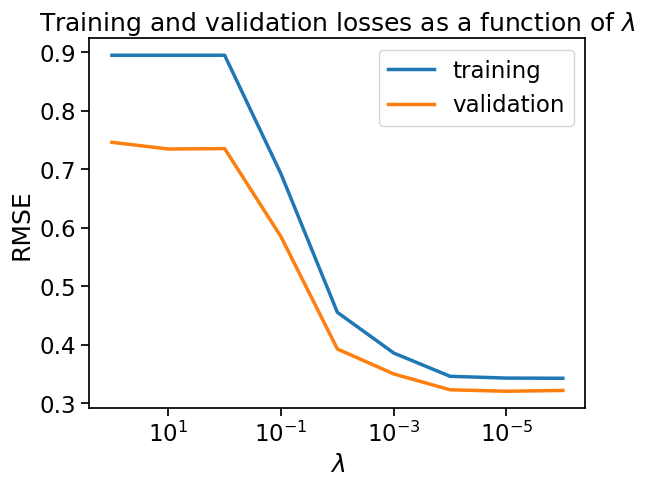

In [43]:
plot_learning_curve(err_df)

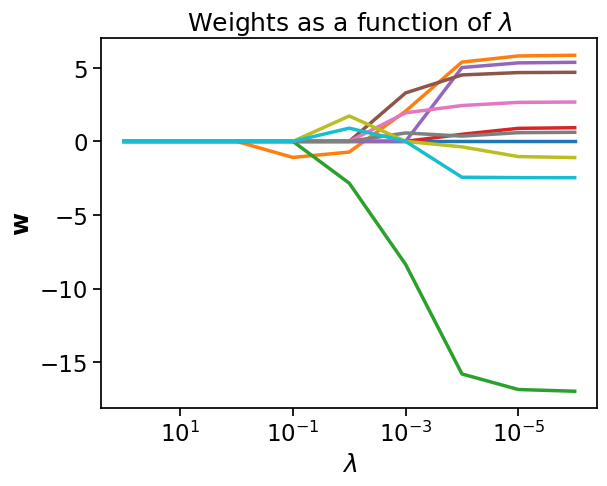

In [44]:
plot_reg_w(w_df)

# Ridge and Lasso Virtualization

### Ridge solution as a formula of $\lambda$
Remember that the ridge regression calculates loss as follows:
$$\mathbf{J(w)} = \frac{1}{2}(\mathbf{Xw -y})^T+\frac{\lambda}{2}\mathbf{w}^T\mathbf{w}$$

Now,
- The first part of equation $(\mathbf{Xw - y})^T(\mathbf{Xw -y})$ gives rise to eliptical contours centered around the linear regression or least squared error solution.
- The second part of equation $\mathbf{w}^T\mathbf{w}$ represents a circle
- The ridge regression solution lies at the intersection betweem contours of these two functions - eliptical and circular contours. The intersection varies as a function $\lambda$
  - As $\lambda \rightarrow 0$ the solution is the solution of least squared error.
  - As $\lambda \rightarrow \infty$ the solution is at the centre of circle, which is a $\bf 0$ vector

### Ridge solution visualization
Steps:
1. Generate Synthetic data.
2. Obtain weight vector for ridge regression model with 100 different values of $\lambda = \{0.0001,...,10\}$ in ascending order.
3. Setup mesh grid of weight values. Let's call it $\bf W$
4. For each $\bf w$ in $\bf W$:
   1. Compute the mean squared error of $\bf w$
   2. Compute the ridge regularization or constant term $\mathbf{w}^T\mathbf{w}$
5. Draw contours for mean squared error and ridge regression constraints
6. Draw path of weight vectors from least mean squared error to the least value of ridge constraints (appears at [0,0])

<img src="../MLT/images/ridge_contour.png"/>

Observe:
- Contours for $L_2$ regularization constraints - circular contours
- Contours for least square error loss function - eliptical contours
- Solution path from least error point of loss function and less penalty point of the constraints as we vary with $\lambda$
  - As $\lambda \rightarrow \infty$ the solution moves closer to the least penalty point
  - As $\lambda \rightarrow 0$ the solution moves closer to the least error point of the loss function.

### Lasso
Remember that the lasso regression calculates loss as follows:
$$\mathbf{J(w)}=\frac{1}{2}(\mathbf{Xw-y})^T(\mathbf{Xw-y})+\frac{\lambda}{2}||\mathbf{w}||_1$$

Now,
- The first part of equation $(\mathbf{Xw-y})^T(\mathbf{Xw-y})$ gives rise to eliptical contours centered around the linear regression or least squared error solution.
- The second part of the equation $||\mathbf{w}||_1$ represents polytope.
- The lasso regression solution lies at the intersection between contours of these two functions - eliptical and polytope contours. The intersection varies as the function of $\lambda$
  - As $\lambda \rightarrow 0$ The solution is least squared error.
  - As $\lambda \rightarrow \infty$ the solution is at the center of polytope which is **0** vector.

Steps:
1. Generate Synthetic data.
2. Obtain weight vector for lasso regression model with 100 different values
3. Setup mesh grid of weight values. Let's call it $\bf W$
4. For each $\bf w$ in $\bf W$:
   1. Compute the mean squared error of $\bf w$
   2. Compute the ridge regularization or constant term $||\mathbf{w}||_1$
5. Draw contours for mean squared error and ridge regression constraints
6. Draw path of weight vectors from least mean squared error to the least value of lasso constraints (appears at [0,0])

<img src="../MLT/images/lasso_contour.png"/>


## Multi-output/Multi-label regression
In case of multi-output regression, there are more than one output labels, all of which are real numbers

### Training data
$\mathbf{D}=(\mathbf{X,Y}) = \{(\mathbf{x}^{(i)},\mathbf{y}^{(i)})\}_{i=0}^n$

Here: $\mathbf{y}^{(i)} \in \R^k$ where *k* is the number of output labels.
Let's generate synthetic data for demonstrating the training set in multi-output regression using ``make_regression`` dataset generation function from ``sklearn`` library.

In [45]:
from cuml.datasets import make_regression

X, y, coef = make_regression(n_samples=100, n_features=10, n_informative=10, bias=1, n_targets=5, shuffle=True, coef=True, random_state=42)

In [46]:
print(X.shape)
print(y.shape)

(100, 10)
(100, 5)


In [47]:
print("Sample training examples:\n",X[:5])
print("Corresponding labels:\n",y[:5])

Sample training examples:
 [[ 9.9586344e-01 -8.9507031e-01 -2.1867580e+00  1.5947448e+00
  -2.1742580e+00 -7.0451647e-01 -1.4634935e+00  1.3428630e-01
   1.6755503e+00  1.4740931e+00]
 [ 1.3100393e+00  9.6110463e-01 -8.9293426e-01 -9.1057265e-01
  -3.3520511e-01 -1.3477879e+00 -5.8046395e-01  9.1662753e-01
  -6.5263385e-01 -2.8935099e-01]
 [-1.4822501e-01  4.9894267e-01  1.5431228e-01 -2.6768804e-01
  -9.2461994e-03 -2.2049883e-01  2.6083758e-01 -2.1450980e+00
   1.1455592e-01 -1.3564651e+00]
 [ 4.1986573e-01 -4.7874051e-01  3.4746417e-01 -7.1249771e-01
  -4.6980017e-04  4.6312732e-01  8.0177766e-01 -1.8627322e-01
  -8.3819902e-01 -6.7581421e-01]
 [ 8.8201910e-01 -4.9321777e-01 -5.0878024e-01  1.0641378e+00
   5.1487958e-01  3.7149870e-01 -5.5216491e-01 -1.6365072e+00
  -1.4108965e+00  6.3585675e-01]]
Corresponding labels:
 [[-109.41969  -147.45209  -297.5036   -257.42682  -214.06569 ]
 [-141.22052   -83.57998  -167.86739  -166.43542   -90.917534]
 [-154.96664  -131.42699   -38.699978 

In [48]:
coef

array([[20.384996 , 35.60398  , 32.86761  , 25.712948 , 38.14277  ],
       [61.43165  , 48.27695  , 21.199186 ,  5.832568 , 97.30924  ],
       [15.886795 , 95.043304 , 66.477165 , 40.610054 , 80.06929  ],
       [74.75556  , 32.967827 ,  6.8792152,  5.7901115, 78.81483  ],
       [42.387936 , 14.209801 , 84.31623  , 61.09412  , 99.50909  ],
       [82.75229  , 30.87361  , 35.5784   , 74.19072  , 20.592348 ],
       [71.47821  , 43.901306 , 83.173256 , 62.288815 ,  5.484801 ],
       [45.171146 , 49.258183 ,  3.6741872, 11.982244 , 16.030075 ],
       [ 7.5849404, 35.59292  , 48.683006 , 14.652642 , 58.54909  ],
       [51.615158 , 44.235676 , 47.614685 , 34.50237  , 14.984825 ]],
      dtype=float32)

#### Preprocessing: Dummy feature and train-test-split

In [49]:
from cuml.model_selection import train_test_split

def add_dummy_feature(x):
    ''' Adds a dummy feature to the dataset.
    Args:
        x: Training dataset
    Returns:
        Training dataset with an addition of dummy feature.
    '''
    # np.ones(X.shape[0]) create a vector of 1's having the same number of 
    # rows as number of samples in dataset.
    return cp.column_stack((cp.ones(x.shape[0]),x))

def preprocess(X, y):
    X_with_dummy = add_dummy_feature(X)
    X_train, X_test, y_train, y_test = train_test_split(X_with_dummy, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


In [50]:
X_train, X_test, y_train, y_test = preprocess(X,y)

#### Model
The linear regression model is exactly same as single label output except that output is now a vector
$$\mathbf{Y}_{n\times k}=\mathbf{X}_{n\times(m+1)}\mathbf{W}_{(m+1)\times k}$$

In this equation, the output label is a matrix $\bf Y$. In order to generate multiple outputs, we need one weight vector per output, Hence a total of $k$ weight vectors corresponding to $k$ outputs.

These are two options for modeling this problem
1. Solve k independent linear regression problems. Gives some flexibility  in using different representation for each problem.
2. Solve a joint learning problem outlined in the equation above.

#### Loss
We use the same loss function as the linear regression i.e sum of squared error
$$\mathbf{J(W)} = \frac{1}{2}(\mathbf{XW-Y})^T(\mathbf{XW-Y})$$

#### Optimization
1. Normal equation
2. Gradient descent and its variants

#### Evaluation
RMSE or loss

In [52]:
# New Linear Regression Class for multi-label regression
class MultiRegression(object):
    '''
    Multi Regression model
    -----------------------
    y = X @ w
    X: A feature matrix
    w: weight vector
    y: label vector
    '''

    def __init__(self):
        self.t0 = 200
        self.t1 = 100000
    
    def predict(self , X:cp.ndarray) -> cp.ndarray:
        '''
        Prediction of output label for a given input.

        Args:
            X: Feature matrix for given inputs.
        Returns:
            y: Output vector as predicted by the given model.
        '''
        y = X @ self.w
        return y
    
    def loss(self, X: cp.ndarray, y: cp.ndarray, reg_rate: float) -> float:
        '''
        Calculate the loss for a model based on known labels

        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model.
        Returns:
            Loss
        '''

        e = y - self.predict(X)
        # return 0.5 * (np.transpose(e) @ e) # Old loss function
        return 0.5* (cp.transpose(e)) @ e + (reg_rate/2) * (cp.transpose(self.w) @ self.w)
    
    def rmse (self, X: cp.ndarray, y: cp.ndarray,reg_rate:float=0) -> float:
        '''
        Calculate the root mean squared error of predictions w.r.t actual label.

        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model
        Returns:
            Loss
        '''
        return cp.sqrt((2/X.shape[0])) * self.loss(X,y,reg_rate)
    

    def fit (self, X: cp.ndarray, y: cp.ndarray, reg_rate: float) -> cp.ndarray:
        '''
        Estimates the parameters of the linear regression model with normal equation

        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model
        Returns:
            weight vector
        '''
        #self.w = np.linalg.pinv(X) @ y
        #return self.w
        self.w = cp.zeros((X.shape[1],y.shape[1]))
        eye = cp.eye(cp.size(X,1)) # Identity matrix
        self.w = cp.linalg.solve(
            reg_rate * eye + X.T @ X,
            X.T @ y
        )
        return self.w
    

    def calculate_gradient(self, X: cp.ndarray, y: cp.ndarray, reg_rate: float) -> cp.ndarray:
        '''
        Calculates gradients of loss function w.r.t weight vector on training set.
        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model
        Returns:
            a vector of gradients.
        '''
        #print(X.shape,y.shape, self.w.shape)
        #print(self.predict(X).shape)
        return cp.transpose(X) @ (self.predict(X) - y) + reg_rate * self.w
    
    def update_weights (self, grad:cp.ndarray, lr: float) -> cp.ndarray:
        '''
        Updates the weights based on the gradient of the loss function.

        Weight updates are carried out with the following formula:
            w_new := w_old - lr * grad
        Args:
            1. w: weight vector
            2. grad: gradient of loss w.r.t w
            3. lr: learning rate
        Returns:
            Updated weight vector
        '''
        return (self.w - lr * grad)

    def learning_schedule(self, t):
        return self.t0 / (t + self.t1)
    
    def gd(self, X: cp.ndarray, y:cp.ndarray, num_epochs:int, lr:float, reg_rate:float=0) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            lr: learning rate

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1],y.shape[1]))
        self.w_all = []
        self.err_all = []
        for i in cp.arange(0,num_epochs):
            dJdw = self.calculate_gradient(X, y,reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y,reg_rate))
            self.w = self.update_weights(dJdw, lr)
        return self.w
    
    def mbgd (self, X:cp.ndarray, y:cp.ndarray, num_epochs:int, batch_size:int,reg_rate:float=0) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            batch_size: Number of examples in a batch

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1], y.shape[1]))
        self.w_all = []
        self.err_all = []
        mini_batch_id = 0

        for epoch in range(num_epochs):
            shuffled_indices = cp.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                xi = X_shuffled[i: i+batch_size]
                yi = y_shuffled[i: i+batch_size]
                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi, yi,reg_rate))

                dJdw = 2/batch_size * self.calculate_gradient(xi, yi,reg_rate)
                self.w = self.update_weights(dJdw, self.learning_schedule(mini_batch_id))
            
        return self.w
    
    def sgd (self, X: cp.ndarray, y:cp.ndarray, num_epochs:int,reg_rate:float=0) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            batch_size: Number of examples in a batch

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1],y.shape[1]))
        self.w_all = []
        self.err_all = []
        
        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index = cp.random.randint(X.shape[0])
                xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi,reg_rate))

                gradients = 2 * self.calculate_gradient(xi, yi,reg_rate)
                lr = self.learning_schedule(epoch * X.shape[0] +i)
                self.w = self.update_weights(gradients, lr)
        
        return self.w

In [54]:
lin_reg = MultiRegression()
w = lin_reg.fit(X_train,y_train,reg_rate=0)

cp.testing.assert_array_almost_equal(w[1:,:],coef,decimal=2)

In [55]:
w

array([[ 1.00000072,  0.99999951,  0.99999945,  1.00000103,  0.99999961],
       [20.3849938 , 35.60398148, 32.86761158, 25.71294745, 38.14277114],
       [61.43164854, 48.27695184, 21.19918695,  5.83256858, 97.30924327],
       [15.88679513, 95.04330479, 66.47716529, 40.61005317, 80.0692908 ],
       [74.75556197, 32.96782718,  6.87921718,  5.79011103, 78.81482908],
       [42.38793596, 14.20979923, 84.31622886, 61.09412079, 99.50908277],
       [82.75228987, 30.87360878, 35.57839975, 74.19071836, 20.59234845],
       [71.47820776, 43.90130743, 83.1732561 , 62.28881463,  5.48480307],
       [45.17114613, 49.25818214,  3.67418859, 11.98224273, 16.03007732],
       [ 7.58494076, 35.59291788, 48.68300533, 14.65264222, 58.54908921],
       [51.61515758, 44.23567706, 47.61468628, 34.50236809, 14.98482543]])

In [56]:
w = lin_reg.gd(X_train, y_train,num_epochs=100,lr=0.01,reg_rate=0)

cp.testing.assert_array_almost_equal(w[1:,:],coef,decimal=2)

In [57]:
w = lin_reg.sgd(X_train, y_train, num_epochs=100, reg_rate=0)

In [58]:
w

array([[ 1.00000198,  1.00000136,  1.00000053,  1.0000019 ,  0.99999953],
       [20.38497945, 35.60396869, 32.86760109, 25.71293704, 38.14277218],
       [61.43165258, 48.27695564, 21.19919013,  5.83257167, 97.30924291],
       [15.88679307, 95.04330328, 66.47716436, 40.61005234, 80.06929147],
       [74.75555833, 32.96782492,  6.87921476,  5.79010824, 78.81482968],
       [42.38794462, 14.20980686, 84.31623494, 61.09412691, 99.50908233],
       [82.75229093, 30.87360868, 35.57840039, 74.19071854, 20.59234827],
       [71.47818535, 43.90129015, 83.17324036, 62.28879967,  5.48480461],
       [45.17113364, 49.25817183,  3.67417984, 11.98223428, 16.03007777],
       [ 7.58494917, 35.59292555, 48.68301199, 14.65264771, 58.54908932],
       [51.61515494, 44.23567574, 47.61468475, 34.50236724, 14.98482552]])